# Практика к занятию 2: решающие деревья (Decision Trees)

**Что попробуем**:
- Реализовать простой классификатор-решающее дерево "с нуля" (поддержка критериев: Gini, Entropy).
- Сравнить реализации (собственная vs `sklearn.tree.DecisionTreeClassifier`).
- Пронаблюдать переобучение и способы борьбы с ним (ограничение глубины, `min_samples_leaf`, `ccp_alpha`).
- Визуализировать дерево и извлечь интерпретируемые правила.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.datasets import make_classification

# Настройки отображения
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.width', 120)

In [ ]:
# help(DecisionTreeClassifier)


## 1. Датасеты для экспериментов

Мы используем два набора данных:
- **Breast Cancer** (sklearn) - реальный бинарный набор для классификации (подойдёт для ROC/AUC).
- **Synthetic** (make_classification) - чтобы показать переобучение (много признаков, мало информативных).


In [ ]:
# Загрузим breast_cancer (binary) и synthetic dataset
bc = datasets.load_breast_cancer(as_frame=True)
X_bc = bc.data
y_bc = bc.target

# Synthetic dataset: небольшое количество информативных фич на фоне шума -> легко переобучается
X_syn, y_syn = make_classification(
    n_samples=400, n_features=30, n_informative=3, n_redundant=5,
    n_repeated=0, n_classes=2, flip_y=0.08, class_sep=1.0, random_state=42
)
X_syn = pd.DataFrame(X_syn, columns=[f'feat_{i}' for i in range(X_syn.shape[1])])
y_syn = pd.Series(y_syn, name='target')

print('Breast cancer data shape:', X_bc.shape)
print('Synthetic data shape:', X_syn.shape)

<class 'numpy.ndarray'>
Breast cancer data shape: (569, 30)
Synthetic data shape: (400, 30)


In [ ]:
X_bc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


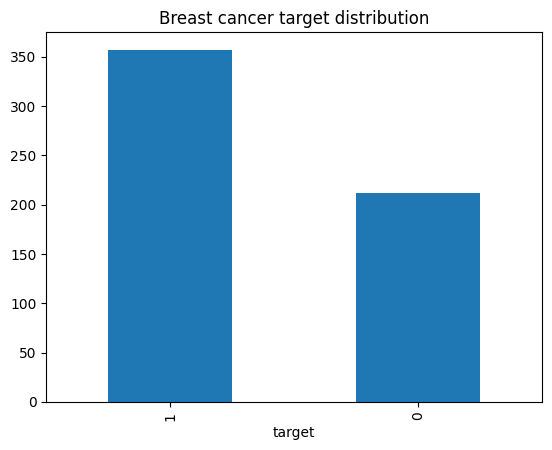

In [ ]:
y_bc.value_counts().plot(kind='bar')
plt.title('Breast cancer target distribution')
plt.show()

In [ ]:
y_bc.value_counts(normalize=True)

,proportion
target,
1,0.627417
0,0.372583


In [ ]:
X_syn.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29
0,1.479527,-0.134125,-1.514157,0.238465,-0.184913,0.061086,0.923865,-1.364649,-0.545020,-0.801862,...,1.996497,-1.531341,-0.870621,0.788122,0.220114,-1.622748,2.440868,-1.219286,-0.076856,-1.965594
1,0.073199,1.149715,-1.377589,-0.041880,-1.325499,-1.073461,1.979286,0.493170,2.086375,-0.134065,...,-1.405168,-1.147342,1.028610,-0.768942,0.278912,-0.725244,0.885702,-0.596603,-0.743859,0.091845
2,-1.232142,0.447862,-0.866089,0.047961,0.003803,-0.083034,-0.200749,0.371094,0.162744,-0.563700,...,-2.093334,0.841528,-0.529938,-0.617637,0.041379,-0.423776,1.015735,-1.894473,0.224626,-3.026224
3,2.461695,1.451706,3.808160,0.187184,-0.161680,0.857949,1.349824,-0.490298,-1.002546,-1.660724,...,0.034026,0.693752,0.027770,0.699816,1.219493,-0.406527,-3.901573,0.167617,0.077767,1.431149
4,1.843926,0.782704,3.125136,-1.941337,-0.607993,0.307221,0.306131,0.374848,-1.839170,1.666753,...,0.472686,2.000108,-1.913332,-0.782757,-0.783585,0.458555,-2.981994,-0.116405,0.619898,0.774807



## 2. Реализация простого Decision Tree (CART-like)

Ниже — минимальная реализация бинарного решающего дерева, поддерживающая:
- критерии качества: **gini** и **entropy**
- параметры регуляризации: `max_depth`, `min_samples_leaf`
- возвращает вероятности классов (важно для ROC AUC)

**2.1. КРИТЕРИИ ИНФОРМАТИВНОСТИ**

In [ ]:
# help(np.bincount)
1 - np.sum((np.bincount(y, minlength=2) / len(y)) ** 2)

np.float64(0.4675300607546925)

In [ ]:
probs = np.bincount(y, minlength=2) / len(y)
probs[probs > 0]

array([0.3726, 0.6274])

In [ ]:
def gini(y, n_classes):
    probs = np.bincount(y, minlength=n_classes) / len(y)
    return 1.0 - np.sum(probs ** 2)

def entropy(y, n_classes):
    probs = np.bincount(y, minlength=n_classes) / len(y)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

def impurity(y, n_classes, criterion):
    if len(y) == 0:
        return 0.0
    return gini(y, n_classes) if criterion == 'gini' else entropy(y, n_classes)

**2.2. ПОИСК ЛУЧШЕГО РАЗБИЕНИЯ**

In [ ]:
help(best_split)

Help on function best_split in module __main__:

best_split(X, y, n_classes, criterion, min_samples_leaf)
    Ищет лучший разбиение узла по всем признакам и порогам.

    X : np.ndarray, shape (n_samples, n_features)
        Признаки.
    y : np.ndarray, shape (n_samples,)
        Метки классов.
    n_classes : int
        Количество классов.
    criterion : str
        Критерий разделения: 'gini' или 'entropy'.
    min_samples_leaf : int
        Минимальное число объектов в листе.

    Возвращает:
        best_feat : int или None
            Индекс признака для лучшего разбиения
        best_thresh : float или None
            Порог для лучшего разбиения
        best_left_idx : np.ndarray bool или None
            Булева маска для левой подвыборки
        best_gain : float
            Прирост информации при лучшем разбиении



In [ ]:
def best_split(X, y, n_classes, criterion, min_samples_leaf):
    """
    Ищет лучший разбиение узла по всем признакам и порогам.

    X : np.ndarray, shape (n_samples, n_features)
        Признаки.
    y : np.ndarray, shape (n_samples,)
        Метки классов.
    n_classes : int
        Количество классов.
    criterion : str
        Критерий разделения: 'gini' или 'entropy'.
    min_samples_leaf : int
        Минимальное число объектов в листе.

    Возвращает:
        best_feat : int или None
            Индекс признака для лучшего разбиения
        best_thresh : float или None
            Порог для лучшего разбиения
        best_left_idx : np.ndarray bool или None
            Булева маска для левой подвыборки
        best_gain : float
            Прирост информации при лучшем разбиении
    """

    n_samples, n_features = X.shape  # число объектов и число признаков

    if n_samples <= 1:
        # Невозможно разделить меньше чем один объект
        return None, None, None, None

    # Вычисляем impurity (Gini/Entropy) родительского узла
    parent_impurity = impurity(y, n_classes, criterion)

    # Инициализация переменных для лучшего разбиения
    best_gain = 0.0
    best_feat = None
    best_thresh = None
    best_left_idx = None

    # Перебираем каждый признак
    for feature in range(n_features):
        values = X[:, feature]              # значения признака
        sorted_idx = np.argsort(values)     # индексы сортировки
        values_sorted = values[sorted_idx]  # отсортированные значения признака
        y_sorted = y[sorted_idx]            # метки в том же порядке

        # Рассматриваем пороги между соседними различными значениями
        for i in range(1, n_samples):
            if values_sorted[i] == values_sorted[i-1]:
                continue  # пропускаем одинаковые значения

            # Среднее между соседними значениями как кандидат порога
            thresh = (values_sorted[i] + values_sorted[i-1]) / 2.0

            # Создаем маску для левой подвыборки
            left_mask = values <= thresh
            left_count = np.sum(left_mask)
            right_count = n_samples - left_count

            # Проверяем минимальное количество объектов в листьях
            if left_count < min_samples_leaf or right_count < min_samples_leaf:
                continue

            # Вычисляем impurity для левой и правой подвыборок
            left_imp = impurity(y[left_mask], n_classes, criterion)
            right_imp = impurity(y[~left_mask], n_classes, criterion)

            # Взвешенное среднее impurity по числу объектов
            weighted_imp = (left_count * left_imp + right_count * right_imp) / n_samples

            # Прирост информации (уменьшение impurity)
            gain = parent_impurity - weighted_imp

            # Если нашли лучший прирост, сохраняем параметры разбиения
            if gain > best_gain:
                best_gain = gain
                best_feat = feature
                best_thresh = thresh
                best_left_idx = left_mask

    # Возвращаем лучшее разбиение
    return best_feat, best_thresh, best_left_idx, best_gain

In [ ]:
arr = np.array([1, 2, 3, 4, 5, 6])
mask = np.array([True, True, True, False, False, False])
arr[mask]

array([1, 2, 3])

**2.3. ПОСТРОЕНИЕ ДЕРЕВА**

In [ ]:
def build_tree(X, y, n_classes, criterion, max_depth, min_samples_leaf, depth=0):
    """
    Рекурсивно строит дерево решений.

    X : np.ndarray, shape (n_samples, n_features)
        Признаки.
    y : np.ndarray, shape (n_samples,)
        Метки классов.
    n_classes : int
        Количество классов.
    criterion : str
        Критерий разделения: 'gini' или 'entropy'.
    max_depth : int or None
        Максимальная глубина дерева.
    min_samples_leaf : int
        Минимальное количество объектов в листе.
    depth : int
        Текущая глубина рекурсии (начинаем с 0).

    Возвращает:
        node : dict
            Словарь, описывающий узел дерева.
    """

    num_samples = X.shape[0]  # количество объектов в текущем узле
    num_classes_in_node = len(np.unique(y))  # сколько уникальных классов в узле

    # Инициализируем словарь узла
    node = {
        'n_samples': num_samples,
        # value — число объектов каждого класса в узле
        'value': np.bincount(y, minlength=n_classes).astype(int).tolist(),
        # predicted_class — наиболее частый класс в узле
        'predicted_class': int(np.argmax(np.bincount(y, minlength=n_classes)))
    }

    # ==== Условия останова ====
    # 1) достигнута максимальная глубина
    # 2) слишком мало объектов для разбиения
    # 3) узел полностью однородный (один класс)
    if (max_depth is not None and depth >= max_depth) or \
       num_samples <= 2 * min_samples_leaf or \
       num_classes_in_node == 1:
        node['is_leaf'] = True
        return node

    # ==== Ищем лучшее разбиение ====
    feat, thresh, left_mask, gain = best_split(X, y, n_classes, criterion, min_samples_leaf)

    # Если разбиение невозможно или не дает прироста информации, делаем лист
    if feat is None or gain <= 0:
        node['is_leaf'] = True
        return node

    # ==== Разбиение узла ====
    node['is_leaf'] = False
    node['feature'] = int(feat)       # индекс признака для разбиения
    node['threshold'] = float(thresh) # порог разбиения

    # Рекурсивно строим левое и правое поддеревья
    node['left'] = build_tree(
        X[left_mask], y[left_mask], n_classes, criterion,
        max_depth, min_samples_leaf, depth + 1
    )
    node['right'] = build_tree(
        X[~left_mask], y[~left_mask], n_classes, criterion,
        max_depth, min_samples_leaf, depth + 1
    )

    return node

**2.4. ОБУЧЕНИЕ**

In [ ]:
def fit_tree(X, y, criterion='gini', max_depth=None, min_samples_leaf=1):
    """
    Строит дерево решений по данным X и меткам y.

    X : pd.DataFrame или np.ndarray, shape (n_samples, n_features)
        Признаки.
    y : pd.Series, pd.DataFrame или np.ndarray, shape (n_samples,)
        Метки классов.
    criterion : str, default='gini'
        Критерий разделения: 'gini' или 'entropy'.
    max_depth : int or None, default=None
        Максимальная глубина дерева.
    min_samples_leaf : int, default=1
        Минимальное количество объектов в листе.

    Возвращает:
        model : dict
            Словарь с деревом и метаданными:
            - 'tree': построенное дерево (словарь с узлами)
            - 'classes_': массив уникальных меток классов
            - 'n_classes_': количество классов
    """

    # Преобразуем входные данные в numpy
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y = np.asarray(y).ravel()
    else:
        y = np.asarray(y)

    # Кодируем метки классов в 0..n_classes-1
    # np.unique с return_inverse делает это автоматически
    classes_, y_encoded = np.unique(y, return_inverse=True)
    n_classes = len(classes_)

    # Строим дерево рекурсивно
    tree = build_tree(X, y_encoded, n_classes, criterion, max_depth, min_samples_leaf)

    # Сохраняем дерево и метаданные в словарь
    model = {
        'tree': tree,
        'classes_': classes_,
        'n_classes_': n_classes
    }

    return model

In [ ]:
num = 5
isinstance(num, float)

df =  pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6]})
type(df) == pd.DataFrame

True

**2.5. ПРЕДСКАЗАНИЕ (МЕТКА)**

In [ ]:
def predict_one(x, node):
    """
    Обход дерева решений для одного объекта.

    x : np.ndarray,
    """
    if node.get('is_leaf', True):
        return node['predicted_class']
    if x[node['feature']] <= node['threshold']:
        return predict_one(x, node['left'])
    else:
        return predict_one(x, node['right'])

def predict_tree(X, model):
    if isinstance(X, pd.DataFrame):
        X = X.values
    preds_idx = [predict_one(x, model['tree']) for x in X]
    return np.array([model['classes_'][i] for i in preds_idx])

**2.6. ПРЕДСКАЗАНИЕ (ВЕРОЯТНОСТЬ)**

In [ ]:
def predict_proba_one(x, node, n_classes):
    if node.get('is_leaf', True):
        counts = np.array(node['value'], dtype=float)
        return counts / counts.sum() if counts.sum()>0 else np.zeros(n_classes)
    if x[node['feature']] <= node['threshold']:
        return predict_proba_one(x, node['left'], n_classes)
    else:
        return predict_proba_one(x, node['right'], n_classes)

def predict_proba_tree(X, model):
    if isinstance(X, pd.DataFrame):
        X = X.values
    n_classes = model['n_classes_']
    probs = np.vstack([predict_proba_one(x, model['tree'], n_classes) for x in X])
    return probs

## 3. Сравнение: наша реализация vs sklearn

На примере Breast Cancer

In [ ]:
def print_metrics(title, y_true, y_pred, y_prob):
    print(f"\n{title}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.3f}")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_prob):.3f}")

In [ ]:
# разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(
    X_bc, y_bc, test_size=0.25, random_state=42, stratify=y_bc
)

In [ ]:
y_train.mean(), y_test.mean(), y.mean()

(np.float64(0.6267605633802817),
 np.float64(0.6293706293706294),
 np.float64(0.6274165202108963))

Наш код:

In [ ]:
# обучаем модель
tree_model = fit_tree(X_train, y_train, criterion='gini', max_depth=3, min_samples_leaf=15)

# предсказания (train)
y_pred_simple_train = predict_tree(X_train, tree_model)
y_prob_simple_train = predict_proba_tree(X_train, tree_model)[:, 1]

# предсказания (test)
y_pred_simple_test = predict_tree(X_test, tree_model)
y_prob_simple_test = predict_proba_tree(X_test, tree_model)[:, 1]

# метрики
print_metrics('Simple tree (gini, train)', y_train, y_pred_simple_train, y_prob_simple_train)
print_metrics('Simple tree (gini, test)', y_test, y_pred_simple_test, y_prob_simple_test)


Simple tree (gini, train)
Accuracy: 0.953
F1-score: 0.963
ROC-AUC: 0.988

Simple tree (gini, test)
Accuracy: 0.958
F1-score: 0.967
ROC-AUC: 0.969


In [ ]:
# разбиение данных
sk_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=15, random_state=42)
sk_tree.fit(X_train, y_train)

# предсказания (train)
y_pred_sk_train = sk_tree.predict(X_train)
y_prob_sk_train = sk_tree.predict_proba(X_train)[:, 1]

# предсказания (test)
y_pred_sk_test = sk_tree.predict(X_test)
y_prob_sk_test = sk_tree.predict_proba(X_test)[:, 1]

# метрики
print_metrics('sklearn tree (gini, train)', y_train, y_pred_sk_train, y_prob_sk_train)
print_metrics('sklearn tree (gini, test)', y_test, y_pred_sk_test, y_prob_sk_test)


sklearn tree (gini, train)
Accuracy: 0.953
F1-score: 0.963
ROC-AUC: 0.988

sklearn tree (gini, test)
Accuracy: 0.958
F1-score: 0.967
ROC-AUC: 0.979


In [ ]:
# tree_model

In [ ]:
sk_tree = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=5, random_state=42)
sk_tree.fit(X_train, y_train)

# Predictions & probabilities (sklearn)
y_pred_sk = sk_tree.predict(X_test)
y_prob_sk = sk_tree.predict_proba(X_test)[:, 1]

# Metrics function
print_metrics('sklearn tree (gini)', y_test, y_pred_sk, y_prob_sk)


sklearn tree (gini)
Accuracy: 0.930
F1-score: 0.944
ROC-AUC: 0.931


### Визуализация sklearn дерева и извлечение правил

In [ ]:
X_train.columns, y_train.unique()

(Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness',
        'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error',
        'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity',
        'worst concave points', 'worst symmetry', 'worst fractal dimension'],
       dtype='object'),
 array([0, 1]))

In [ ]:
bc.target_names

array(['malignant', 'benign'], dtype='<U9')

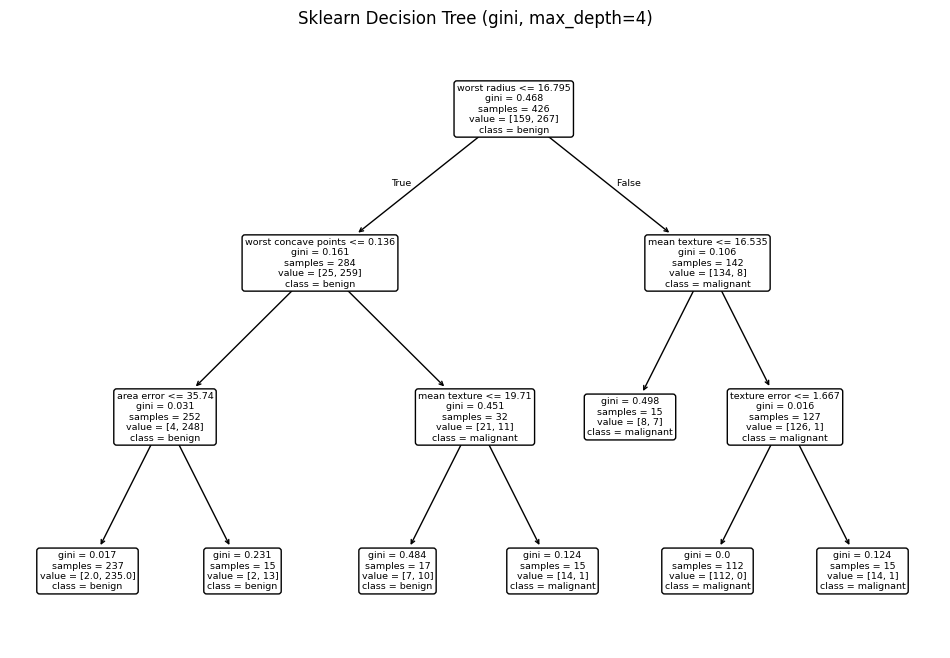

Extracted rules (sklearn):

|--- worst radius <= 16.80
|   |--- worst concave points <= 0.14
|   |   |--- area error <= 35.74
|   |   |   |--- class: 1
|   |   |--- area error >  35.74
|   |   |   |--- class: 1
|   |--- worst concave points >  0.14
|   |   |--- mean texture <= 19.71
|   |   |   |--- class: 1
|   |   |--- mean texture >  19.71
|   |   |   |--- class: 0
|--- worst radius >  16.80
|   |--- mean texture <= 16.53
|   |   |--- class: 0
|   |--- mean texture >  16.53
|   |   |--- texture error <= 1.67
|   |   |   |--- class: 0
|   |   |--- texture error >  1.67
|   |   |   |--- class: 0



In [ ]:
plt.figure(figsize=(12,8))
plot_tree(sk_tree, feature_names=X.columns, class_names=bc.target_names, filled=False, rounded=True)
plt.title('Sklearn Decision Tree (gini, max_depth=4)')
plt.show()

# Text rules from sklearn
rules = export_text(sk_tree, feature_names=list(X.columns))
print('Extracted rules (sklearn):\n')
print(rules[:1000])  # печатаем начало (можно прокрутить)

In [ ]:
# # Train/test split for synthetic
# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
#     X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn
# )

# depths = list(range(1, 21))
# train_scores, test_scores = evaluate_depths(depths, min_samples_leaf=1)

# plt.figure(figsize=(8,5))
# plt.plot(depths, train_scores, label='train score')
# plt.plot(depths, test_scores, label='test score')
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')
# plt.title('Overfitting demo: train vs test by max_depth (synthetic)')
# plt.legend()
# plt.grid(True)
# plt.show()


## 4. Демонстрация переобучения (Synthetic dataset)

Натренируем дерево с большой максимальной глубиной и покажем, что оно переобучается.
Затем применим регулизацию (ограничение глубины и min_samples_leaf) и сравним метрики.

In [ ]:
# Helper to evaluate different depths
def evaluate_depths(depths, min_samples_leaf=1):
    train_scores = []
    test_scores = []
    for d in depths:
        clf = DecisionTreeClassifier(max_depth=d, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train_s, y_train_s)
        train_scores.append(clf.score(X_train_s, y_train_s))
        test_scores.append(clf.score(X_test_s, y_test_s))
    return train_scores, test_scores

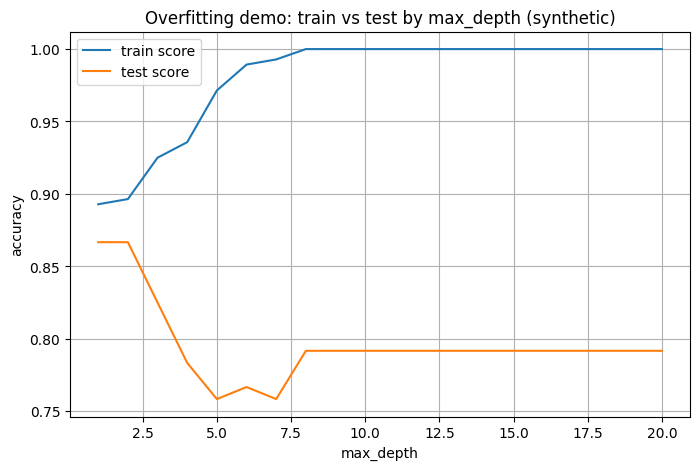

In [ ]:
# Train/test split for synthetic
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn
)

depths = list(range(1, 21))
train_scores, test_scores = evaluate_depths(depths, min_samples_leaf=1)

plt.figure(figsize=(8,5))
plt.plot(depths, train_scores, label='train score')
plt.plot(depths, test_scores, label='test score')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Overfitting demo: train vs test by max_depth (synthetic)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Регуляризация

Покажем влияние `min_samples_leaf` и `ccp_alpha` (скользящая регуляризация стоимости сложности) на качество.

   min_samples_leaf  train_acc  test_acc
0                 1   1.000000  0.791667
1                 5   0.939286  0.833333
2                10   0.914286  0.841667
3                20   0.900000  0.833333
4                50   0.892857  0.866667

Number of candidate alphas: 14


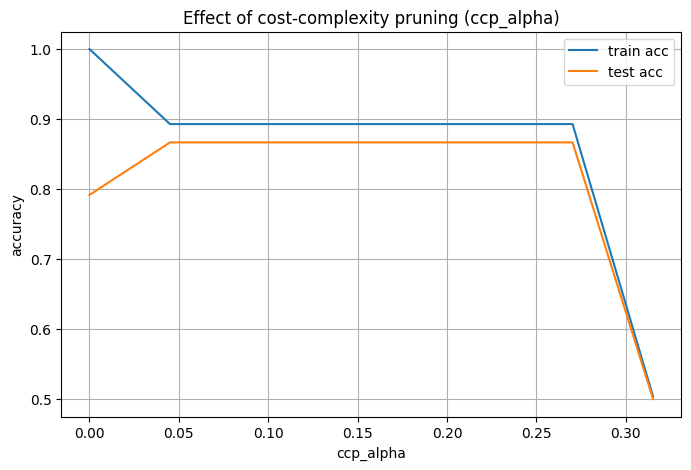

In [ ]:
# Vary min_samples_leaf
leaf_vals = [1, 5, 10, 20, 50]
results = []
for leaf in leaf_vals:
    clf = DecisionTreeClassifier(max_depth=None, min_samples_leaf=leaf, random_state=42)
    clf.fit(X_train_s, y_train_s)
    results.append((leaf, clf.score(X_train_s, y_train_s), clf.score(X_test_s, y_test_s)))

df_res = pd.DataFrame(results, columns=['min_samples_leaf', 'train_acc', 'test_acc'])
print(df_res)

# Cost complexity pruning path (sklearn) - compute effective alphas
clf_full = DecisionTreeClassifier(random_state=42)
path = clf_full.cost_complexity_pruning_path(X_train_s, y_train_s)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('\nNumber of candidate alphas:', len(ccp_alphas))

# Train trees for some alphas and plot test accuracy
train_scores = []
test_scores = []
alphas_to_test = np.linspace(ccp_alphas.min(), ccp_alphas.max(), num=8)
for a in alphas_to_test:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=float(a))
    clf.fit(X_train_s, y_train_s)
    train_scores.append(clf.score(X_train_s, y_train_s))
    test_scores.append(clf.score(X_test_s, y_test_s))

plt.figure(figsize=(8,5))
plt.plot(alphas_to_test, train_scores, label='train acc')
plt.plot(alphas_to_test, test_scores, label='test acc')
plt.xlabel('ccp_alpha')
plt.ylabel('accuracy')
plt.title('Effect of cost-complexity pruning (ccp_alpha)')
plt.legend()
plt.grid(True)
plt.show()